In [137]:
import os
from skimage import io
import matplotlib.pyplot as plt
import zarr
import numpy as np
# import cv2

### All Paths

In [206]:
RAW_PATH = '../../data/cells/raw/train/'
MASK_KEY = '_instances'
EXTENSION = '.tif'
ZARR_PATH = '../../data/cells/raw/all.zar'
RAW = 'raw'
GT = 'ground_trouth'
os.listdir(RAW_PATH)

['ND8_DIV0+4h_20x_noConfinment_6_ch_4_instances.tif',
 'ND8_DIV0+4h_20x_noConfinment_6_ch_4.tif',
 '20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4_instances.tif',
 '20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4.tif']

In [201]:
def readImg(path):
    print('Reading image: {} ..'.format(path))
    im = io.imread(path)
    return im

def generate_pairs(folder_path):
    print(folder_path)
    files = os.listdir(folder_path)
    pairs = {}
    for f in files:
        if f.endswith(EXTENSION):
            if MASK_KEY in f:
                inp_img = f.replace(MASK_KEY,'')
                if inp_img in files:
                    pairs[os.path.join(folder_path,inp_img)]=os.path.join(folder_path,f)
#                     pairs.append({os.path.join(folder_path,inp_img):os.path.join(folder_path,f)})
                else:
                    print('ERROR! {} not found'.format(inp_img))
    print("Found {} pairs.".format(len(pairs)))
    return pairs

def normalize_mask(mask,list_vals):
    size = list_vals.size
    shape = (tuple([size])+mask.shape)
    result = np.zeros(shape, dtype=float)
    for i in range(size):
        tmp = np.zeros_like(mask)
        tmp [mask == list_vals[i]] = 1.0
        result[i] = tmp
    return result

In [212]:
def create_zarr(raw_path,zar_path):
    pairs = generate_pairs(raw_path)
    size = len(pairs)
    root = zarr.open(zar_path, mode='w')
    initial = True
    for i,(image_path, mask_path) in enumerate(pairs.items()):
        print(i)
        im_image = readImg(image_path)
        im_mask = readImg(mask_path)
        if(initial):
            # removed the last value because it is the error category
            mask_values = np.unique(mask)[:-1]
            shape_image = (tuple([size])+im_image.shape)
            shape_mask = (tuple([size,mask_values.size])+im_mask.shape)
            print('The value to be activated in mask: {} '.format(uniqueValues))
            print('Img size: {} {} | Mask size: {} {}'.format(shape_image,type(im_image),shape_mask,type(im_mask)))
            root.zeros(RAW, shape=shape_image, chunks=(1,256, 256,1), dtype='f4')
            root.zeros(GT, shape=shape_mask, chunks=(1,1,256, 256), dtype='f4')
            initial = False
        
        normalized_mask = normalize_mask(im_mask,mask_values)
        print('The normalized mask: {} '.format(normalized_mask.shape))
        root[RAW][i] = im_image
        root[GT][i] = normalized_mask
        
create_zarr(RAW_PATH,ZARR_PATH)

../../data/cells/raw/train/
Found 2 pairs.
0
Reading image: ../../data/cells/raw/train/ND8_DIV0+4h_20x_noConfinment_6_ch_4.tif ..
Reading image: ../../data/cells/raw/train/ND8_DIV0+4h_20x_noConfinment_6_ch_4_instances.tif ..
The value to be activated in mask: [0. 4. 5. 6. 7.] 
Img size: (2, 1024, 1024, 4) <class 'numpy.ndarray'> | Mask size: (2, 4, 1024, 1024) <class 'numpy.ndarray'>
The normalized mask: (4, 1024, 1024) 
1
Reading image: ../../data/cells/raw/train/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4.tif ..
Reading image: ../../data/cells/raw/train/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4_instances.tif ..
The normalized mask: (4, 1024, 1024) 


In [184]:
# plt.imshow(bg)

In [216]:
file = zarr.open(ZARR_PATH, mode='r')

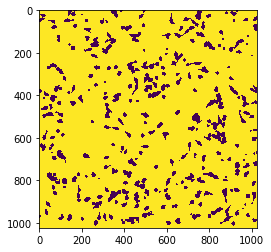

In [222]:
plt.imshow(file[GT][0,0,:,:])